## per 변수들 추가 안한 데이터로 학습해서 추가한 것과 cost 비교해 보기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## 데이터 불러오기
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#층화추출 위해 income(종속변수)를 군집화
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]): #income_cat 칼럼 비율을 같게 하여 housing 데이터를 층화 split
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [5]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [6]:
print(len(strat_train_set), len(strat_test_set))
strat_train_set.head()

16512 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## 데이터 준비

In [7]:
#label 데이터와 나머지를 분리
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [8]:
#숫자형 변수가 아닌 범주형 변수 분리. 그리고 one hot
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [10]:
housing_num_tr[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744])

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [12]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)), #ocean_proximity 열만 선택
    ('cat_encoder', OneHotEncoder(categories='auto', sparse=False))
])

In [13]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [14]:
housing_prepared.shape # 8개의 숫자형 변수 + 범주형 변수(ocean_proximity)를 one hot 한 5개의 변수

(16512, 13)

In [15]:
# 선형회귀
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #root mean squared error(RMSE) 측정

69050.98178244587

In [16]:
# RandomizedSearchCV로 본격적으로 학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=10, scoring = 'neg_mean_squared_error',
                               random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [17]:
print(rnd_search.best_params_)
print(rnd_search.best_estimator_)
print(rnd_search.best_score_)

{'max_features': 7, 'n_estimators': 180}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=180,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
-2399263839.359457


In [18]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse # 46459. 47758(GridSearchCV + 3개 칼럼 추가한 것)과 큰 차이는 없음

46459.023005813484

In [19]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [20]:
housing.head()
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

## 변수들 가지고 차원축소 해보기 (n=2 or 3)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(housing_prepared)
print(pca.explained_variance_ratio_)

[0.45017224 0.22797502]


In [22]:
pca = PCA()
pca.fit(housing_prepared)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [23]:
print(d)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(housing_prepared)

6


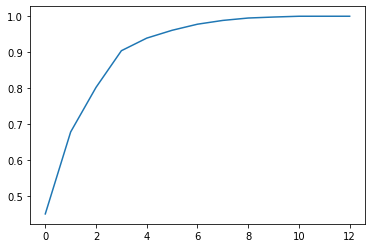

In [24]:
plt.plot(cumsum)

In [25]:
#2차원으로 축소한 데이터 시각화 해 보기
df = pd.DataFrame(X2D) 
df.columns = ["x", "y"]

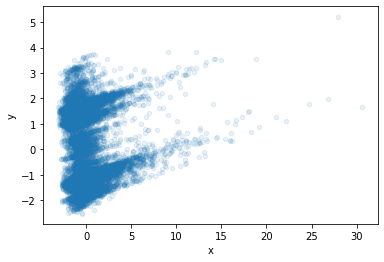

In [26]:
df.plot(kind = "scatter", x = "x", y = "y", alpha = 0.1)

In [27]:
pca = PCA(n_components=3)
X3D = pca.fit_transform(housing_prepared)
print(pca.explained_variance_ratio_)

[0.45017224 0.22797502 0.12398332]


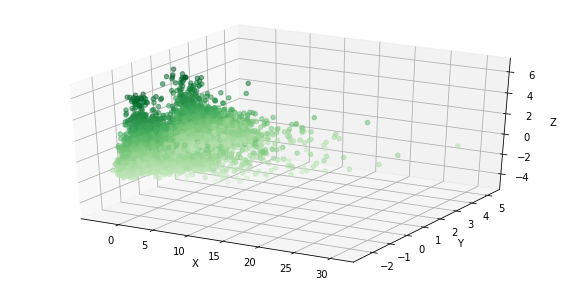

In [28]:
df3 = pd.DataFrame(X3D)
df3.columns = ["x", "y", "z"]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(df3.x, df3.y, df3.z, c = df3.z, s = 20, alpha = 0.5, cmap=plt.cm.Greens)
# 결과: 2차원 plot과 산점도가 비슷한 것 같음(꼬리 두 개가 보이는 형태)

Wall time: 2min 7s


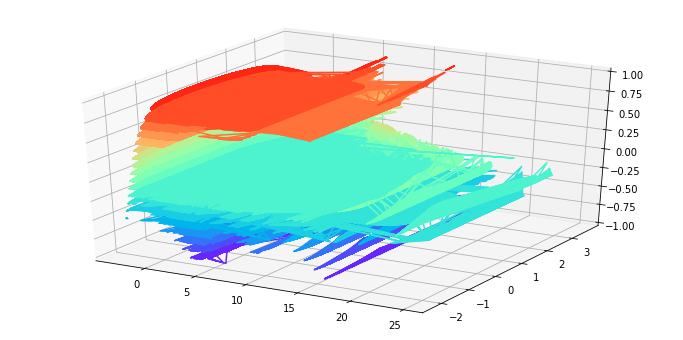

In [29]:
%%time
# contour 3d
x, y = np.meshgrid(df.x.head(1000), df.y.head(1000)) #전체 데이터로 하면 MemoryError. 1000개만 해봄
z = np.sin(np.sqrt(x**2 + y**2))

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
ax.contour3D(x, y, z, 20, cmap=plt.cm.rainbow)
plt.savefig("contour.svg")